<a href="https://colab.research.google.com/github/Pravallika41296/IANNWTF_Homework_Group24/blob/main/IANNWTF_Homework04_Group24_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing all the necessary packages
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [3]:
#Loading the dataset
#Loading 80% samples into training dataset and remaining 20% into test dataset
(train_ds, test_ds), ds_info = tfds.load(
    'malaria',
    #split = 'train',
    with_info = True,
    split=['train[:80%]','train[80%:]'], 
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete0AWV8M/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
#Normalization
train_ds = train_ds.map(lambda image, label : (tf.image.per_image_standardization(image), label))
test_ds = test_ds.map(lambda image, label : (tf.image.per_image_standardization(image), label))

#plots = tfds.show_examples(train_ds, ds_info)

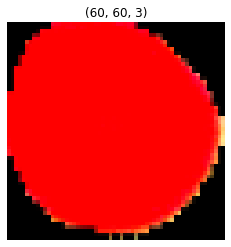

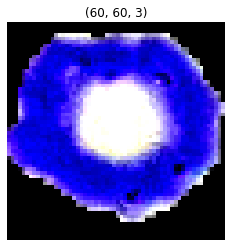

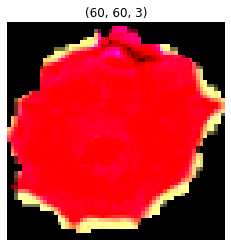

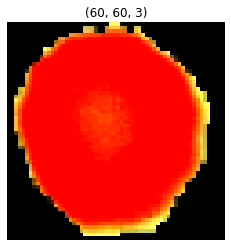

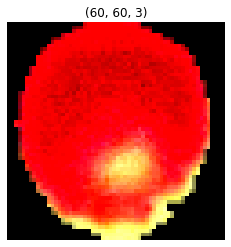

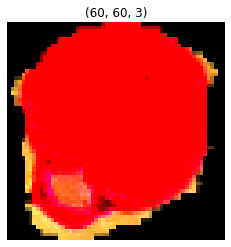

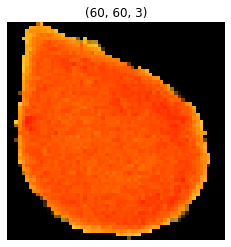

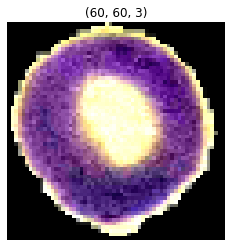

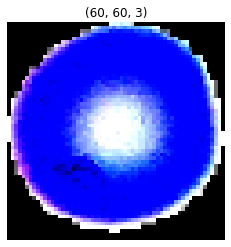

In [6]:
resized_train_ds = train_ds.map(lambda image, label : (tf.image.resize_with_pad(image, 60,60), tf.one_hot(label, 2)))
for image , label in resized_train_ds.take(9):
  plt.imshow(np.uint8(image))
  plt.title(image.shape)
  plt.axis("off")
  plt.show()

train_dataset = resized_train_ds.batch(64)
train_dataset = train_dataset.shuffle(buffer_size=128)

resized_test_ds = test_ds.map(lambda image, label :(tf.image.resize_with_pad(image, 60,60), tf.one_hot(label, 2)))
test_dataset = resized_test_ds.batch(64)
test_dataset = test_dataset.shuffle(buffer_size=128)

#caching 
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
#Constructing the network architecture
class Model(Layer): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        #Defining a 2D convolutional layer, with 32 kernels, each kernel is of the dim 3x3 
        self.conv_1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(60,60,3)
                                               )
        #downsizing the sample by taking the max of the window size, i'm assuming that the default pool size is 2x2
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.conv_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters=24, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        #Convert the input to a 1D vector
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        #10 output units, with softmax activation function
        self.output_layer = tf.keras.layers.Dense(2,
                                                  activation=tf.keras.activations.softmax)


    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x


In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (image, target) in test_data:
    prediction = model(image)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 25
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss,test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss,_ = test(model, train_dataset, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (image,label) in train_dataset:
        train_loss = train_step(model, image, label, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    #print("test losses",test_losses )
    test_accuracies.append(test_accuracy)
    print("test accuracies",test_accuracies )



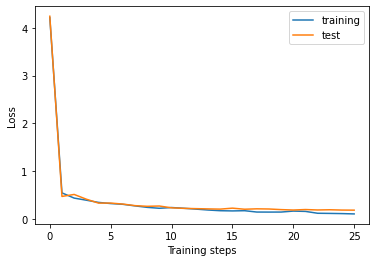

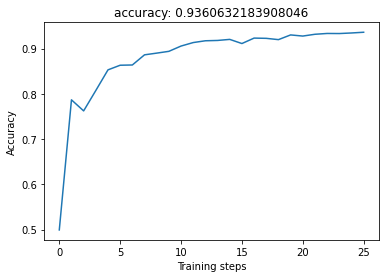

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()